# Edge Detection and Coordinates Clockwise Sorting for Fourier Transform Drawings

In this repo we will going to use the [opencv](https://pypi.org/project/opencv-python/) python library in order to perform edge detection. After that, we will find the coordinates of points belonging to those edges and store them into an array for their later sorting in clockwise fashion.

Let's start by importing the needed libraries.

In [1]:
import numpy
import cv2
from matplotlib import pyplot
%matplotlib inline

Read the image, make sure you're using the correct path!

In [2]:
import os
path1 = "star.jpg"
if os.path.isfile(path1):
    img1 = cv2.imread(path1, 0)
else:
    print ("The file " + path1 + " does not exist.")
print(type(img1))

<class 'numpy.ndarray'>


Now, let's find the edges by using the [Canny Edge Detection](https://docs.opencv.org/3.1.0/da/d22/tutorial_py_canny.html) in OpenCv.

In [3]:
edges = cv2.Canny(img1,100,200)
print(type(edges))

<class 'numpy.ndarray'>


Let's plot the original image along with the Edge image in order to check the reliability of the algorithm.

(Text(0.5, 1.0, 'Edge Image'),
 ([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>))

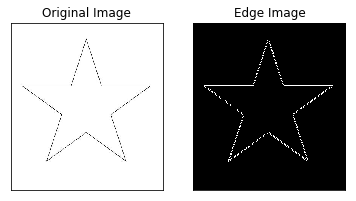

In [4]:
pyplot.subplot(121),pyplot.imshow(img1,cmap = 'gray')
pyplot.title('Original Image'), pyplot.xticks([]), pyplot.yticks([])
pyplot.subplot(122),pyplot.imshow(edges,cmap = 'gray')
pyplot.title('Edge Image'), pyplot.xticks([]), pyplot.yticks([])

Now, we will iterate over all the white pixels of the Edge image. By doing so, we can list their coordinates which will be useful at a later stage.

In [5]:
plotting = []
for index, x_axis in enumerate(edges):
    for y, x in enumerate(x_axis):
        if x == 255:
            plotting.append((y, index))

As the point of all of this image edge detection is to find the edges' coordinates and use them to feed a "Drawing Machine". One has to assure a proper sweep direction in the drawing process, i.e. a certain path. Otherwise, when one would try to "draw" using the Fourier Transform, one would get an image very similar to the one below.  

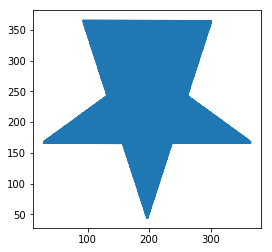

In [6]:
plotting = numpy.array(plotting)
pyplot.figure()
pyplot.plot(plotting[:, 0], plotting[:, 1])
pyplot.gca().set_aspect("equal")

In order to fix that, one has to sort the coordinates in clockwise type fashion, and so the Fourier Transform drawing will follow a suitable path. If the default path (above) is followed, the draw will look like as if the drawing is being "printed" by the Epicycles, this is not visually interesting. For more information about the nature of the problem as well as its solution, go to Stack Oveflow [question](https://stackoverflow.com/questions/41855695/sorting-list-of-two-dimensional-coordinates-by-clockwise-angle-using-python/41856340#41856340).

In [7]:
import math

origin = [img1.shape[0]//2, img1.shape[1]//2]
refvec = [500, 1]

def clockwiseangle_and_distance(point):
    # Vector between point and the origin: v = p - o
    vector = [point[0]-origin[0], point[1]-origin[1]]
    # Length of vector: ||v||
    lenvector = math.hypot(vector[0], vector[1])
    # If length is zero there is no angle
    if lenvector == 0:
        return -math.pi, 0
    # Normalize vector: v/||v||
    normalized = [vector[0]/lenvector, vector[1]/lenvector]
    dotprod  = normalized[0]*refvec[0] + normalized[1]*refvec[1]     # x1*x2 + y1*y2
    diffprod = refvec[1]*normalized[0] - refvec[0]*normalized[1]     # x1*y2 - y1*x2
    angle = math.atan2(diffprod, dotprod)
    # Negative angles represent counter-clockwise angles so we need to subtract them 
    # from 2*pi (360 degrees)
    if angle < 0:
        return 2*math.pi+angle, lenvector
    # I return first the angle because that's the primary sorting criterium
    # but if two vectors have the same angle then the shorter distance should come first.
    return angle, lenvector

In [8]:
sorted_coordinates = sorted(plotting, key=clockwiseangle_and_distance)

Once the coordinates have been clockwisely sorted with respect to the center of the image. One could now draw the figure by following a reasonable path, as it can be seen from the following plot.

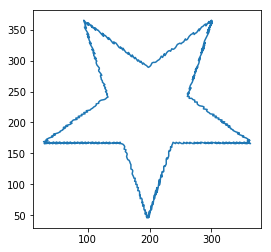

In [9]:
sorted_coordinates = numpy.array(sorted_coordinates)
pyplot.figure()
pyplot.plot(sorted_coordinates[:, 0][::5], sorted_coordinates[:, 1][::5])
pyplot.gca().set_aspect("equal")

Now, let's define a given amount of skipping points given that we will not need all of them in the drawing process, is way too much detail and the draw will run very slow.

In [10]:
skip = 10

Let's now write the file which fill feed the Drawing algorithm as the arbitrary function to make the discrete Fourier transform "converge". The Fourier transform was made in [p5](https://p5js.org/libraries/) library.  It is worth to mention that, this algorithm albeit it is functional, it is restricted to very simple shapes, for which one can obtain a clear path with respect to a given "center" in order to do this procedure more general, one has to adaptatively update the center with respect to which the neighboring points are being clockwisely sorted. One could think of a solution kind of similar to the one suggested in [here](https://stackoverflow.com/questions/55344597/sorting-a-complicated-collection-of-2d-euclidian-points-in-in-clockwise-counterc).

Once the coordinates are sorted, it is time to write them down properly, so that the epicycles of the Fourier transform, can follow the path traced by these points, which can be thought of as an arbitrary function.

In [11]:
filename = "image_sorted.js"
outsample = open(filename, mode="w")
outsample.write("let drawing = [ \n")
for coordinate in sorted_coordinates[::skip]:
    x = coordinate[0]
    y = coordinate[1]
    outsample.write("{x: %f, y: %f }, \n"%(x, y))
outsample.write("] ;")
outsample.close()

After all of this procedure, one would end up with a file named *image_sorted.js* which will be stored in the *_drawing_* variable and will be used in *_sketch.js_*. You can see this in action by opening the **_index.html_** file of this repo in your preferred web browser.